<a href="https://colab.research.google.com/github/chuviethongfpt/atom-assignments/blob/main/Home_Assignment__04_CVH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install duckdb

In [28]:
import requests # -> Để call API
import json # -> Xử lý file JSON
import pandas as pd # -> Thư viện xử lý dữ liệu dạng bảng
import re # -> Thư viện xử lý text: regular expressions
from datetime import datetime as dt # -> Thư viện xử lý dữ liệu thời gian
import duckdb # -> Thư viện "giả lập" xử lý dữ liệu bằng SQL
import numpy as np


# STEP 0: XEM LẠI DATA ĐÃ CÓ (SLACK API)
Ở bước đầu tiên, ta xem lại tất cả các data của DATACracy Atom mà ra đã biết:

Data từ Slack API:


*   Danh sách thành viên
*   Danh sách các channels
*   Lịch sử tin nhắn trên các channels

Data do dự án tự collect - File CSV (trích xuất từ Google Spreadsheet):

*   Danh sách thành viên được phân theo vị trí (mentors, learners, BTC)

===> Các dữ liệu này lần lượt được lấy bằng code bên dưới.

In [29]:
## Load Token file 
## WARNING!! --- Put it in gitignore and DO NOT print out to notebook
with open('env_variable.json', 'r') as j:
    json_data = json.load(j)

# 0.1. Pull List of Members

In [30]:
# 1. LIST OF SLACK MEMBERS 

## Pull list of member as JSON
## Gọi API từ Endpoints (Input - Token được đưa vào Headers)
## Challenge: Thử gọi API này bằng Postman
endpoint = "https://slack.com/api/users.list"
headers = {"Authorization": "Bearer {}".format(json_data['SLACK_BEARER_TOKEN'])}
response_json = requests.post(endpoint, headers=headers).json() 
user_dat = response_json['members']

## Convert to CSV
user_dict = {'user_id':[],'name':[],'display_name':[],'real_name':[],'title':[],'is_bot':[]}
for i in range(len(user_dat)):
  user_dict['user_id'].append(user_dat[i]['id'])
  user_dict['name'].append(user_dat[i]['name'])
  user_dict['display_name'].append(user_dat[i]['profile']['display_name'])
  user_dict['real_name'].append(user_dat[i]['profile']['real_name_normalized'])
  user_dict['title'].append(user_dat[i]['profile']['title'])
  user_dict['is_bot'].append(user_dat[i]['is_bot'])

user_df = pd.DataFrame(user_dict) 
user_df = user_df.replace('', np.nan) # -> replace khoảng trắng bằng giá trị NULL (nan)
user_df.head()

,user_id,name,display_name,real_name,title,is_bot
0,USLACKBOT,slackbot,Slackbot,Slackbot,NaN,False
1,U01AT4T75JB,loclexuan26392,Loc Le Xuan,Loc Le Xuan,NaN,False
2,U01AVDY7JET,locle.ds,Loc Le Xuan,Loc Le Xuan,NaN,False
3,U01BE2PR6LU,maianhdang.ftu,MAD,Dặng Huỳnh Mai Anh,Technical Contents,False
4,U01C48T7S1J,huyenhoang.design,Thanh Huyen Hoang,Thanh Huyen Hoang,NaN,False


In [31]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       75 non-null     object
 1   name          75 non-null     object
 2   display_name  50 non-null     object
 3   real_name     75 non-null     object
 4   title         6 non-null      object
 5   is_bot        75 non-null     bool  
dtypes: bool(1), object(5)
memory usage: 3.1+ KB


# 0.2. List of Channels

In [32]:
# 2. LIST OF SLACK CHANNELS

endpoint2 = "https://slack.com/api/conversations.list"
data = {'types': 'public_channel,private_channel'} # -> CHECK: API Docs https://api.slack.com/methods/conversations.list/test
response_json = requests.post(endpoint2, headers=headers, data=data).json() 
channel_dat = response_json['channels']

channel_dict = {'channel_id':[], 'channel_name':[], 'is_channel':[],'creator':[],'created_at':[],'topics':[],'purpose':[],'num_members':[]}
for i in range(len(channel_dat)):
  channel_dict['channel_id'].append(channel_dat[i]['id'])
  channel_dict['channel_name'].append(channel_dat[i]['name'])
  channel_dict['is_channel'].append(channel_dat[i]['is_channel'])
  channel_dict['creator'].append(channel_dat[i]['creator'])
  channel_dict['created_at'].append(dt.fromtimestamp(float(channel_dat[i]['created'])))
  channel_dict['topics'].append(channel_dat[i]['topic']['value'])
  channel_dict['purpose'].append(channel_dat[i]['purpose']['value'])
  channel_dict['num_members'].append(channel_dat[i]['num_members'])

channel_df = pd.DataFrame(channel_dict) 
channel_df = channel_df.replace('', np.nan) # -> replace khoảng trắng bằng giá trị NULL (nan)
channel_df.head()

,channel_id,channel_name,is_channel,creator,created_at,topics,purpose,num_members
0,C01B4PVGLVB,general,True,U01BE2PR6LU,2020-09-23 10:25:03,NaN,This is the one channel that will always inclu...,65
1,C01BYH7JHB5,contents,True,U01BE2PR6LU,2020-10-05 07:28:09,NaN,NaN,12
2,C01CAMNCJJV,branding-design,True,U01AVDY7JET,2020-10-05 03:16:30,NaN,NaN,9
3,C01U6P7LZ8F,atom-assignment1,True,U01BE2PR6LU,2021-04-17 07:00:04,Assigment#1 - Python Basics &amp; Spreadsheet ...,Where learners submit assignments and give rev...,44
4,C01UL6K1C7L,atom-week1,True,U01BE2PR6LU,2021-04-16 17:44:32,TOPIC: Data Strategy. Metrics Design. Spreadsh...,TOPIC: Data Strategy. Metrics Design. Spreadsh...,43


In [33]:
channel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   channel_id    19 non-null     object        
 1   channel_name  19 non-null     object        
 2   is_channel    19 non-null     bool          
 3   creator       19 non-null     object        
 4   created_at    19 non-null     datetime64[ns]
 5   topics        6 non-null      object        
 6   purpose       13 non-null     object        
 7   num_members   19 non-null     int64         
dtypes: bool(1), datetime64[ns](1), int64(1), object(5)
memory usage: 1.2+ KB


# 0.3. Message Data

In [34]:
endpoint3 = "https://slack.com/api/conversations.history"

In [35]:
msg_dict = {'channel_id':[],'msg_id':[], 'msg_ts':[], 'user_id':[], 'latest_reply':[],'reply_user_count':[],'reply_users':[],'github_link':[]}
for channel_id, channel_name in zip(channel_df['channel_id'], channel_df['channel_name']):
  print('Channel ID: {} - Channel Name: {}'.format(channel_id, channel_name))
  try:
    data = {"channel": channel_id} 
    response_json = requests.post(endpoint3, data=data, headers=headers).json()
    msg_ls = response_json['messages']
    for i in range(len(msg_ls)):
      if 'client_msg_id' in msg_ls[i].keys():
        msg_dict['channel_id'].append(channel_id)
        msg_dict['msg_id'].append(msg_ls[i]['client_msg_id'])
        msg_dict['msg_ts'].append(dt.fromtimestamp(float(msg_ls[i]['ts'])))
        msg_dict['latest_reply'].append(dt.fromtimestamp(float(msg_ls[i]['latest_reply'] if 'latest_reply' in msg_ls[i].keys() else 0))) ## -> No reply: 1970-01-01
        msg_dict['user_id'].append(msg_ls[i]['user'])
        msg_dict['reply_user_count'].append(msg_ls[i]['reply_users_count'] if 'reply_users_count' in msg_ls[i].keys() else 0)
        msg_dict['reply_users'].append(msg_ls[i]['reply_users'] if 'reply_users' in msg_ls[i].keys() else 0) 
        ## -> Censor message contains tokens
        text = msg_ls[i]['text']
        github_link = re.findall('(?:https?://)?(?:www[.])?github[.]com/[\w-]+/?', text)
        msg_dict['github_link'].append(github_link[0] if len(github_link) > 0 else np.nan)
  except:
    print('====> '+ str(response_json))

Channel ID: C01B4PVGLVB - Channel Name: general
Channel ID: C01BYH7JHB5 - Channel Name: contents
====> {'ok': False, 'error': 'not_in_channel'}
Channel ID: C01CAMNCJJV - Channel Name: branding-design
====> {'ok': False, 'error': 'not_in_channel'}
Channel ID: C01U6P7LZ8F - Channel Name: atom-assignment1
Channel ID: C01UL6K1C7L - Channel Name: atom-week1
Channel ID: C01ULCHGN75 - Channel Name: atom-general
====> {'ok': False, 'error': 'not_in_channel'}
Channel ID: C020VMT58JK - Channel Name: topics-data-analytics
Channel ID: C0213MNH9L6 - Channel Name: topics-python
Channel ID: C0213N56M2A - Channel Name: topics-materials
Channel ID: C021FSDN7LJ - Channel Name: atom-assignment2
Channel ID: C021KLB0DSB - Channel Name: discuss-group3
Channel ID: C021KLB90GP - Channel Name: discuss-group4
Channel ID: C02204B2CD6 - Channel Name: atom-week2
Channel ID: C0220KU9399 - Channel Name: discuss-group1
Channel ID: C0226D3LEQ4 - Channel Name: atom-week3
Channel ID: C0227A51SAY - Channel Name: atom-ass

In [36]:
msg_df = pd.DataFrame(msg_dict)
msg_df = msg_df.replace('', np.nan) # -> replace khoảng trắng bằng giá trị NULL (nan)
msg_df.tail()

,channel_id,msg_id,msg_ts,user_id,latest_reply,reply_user_count,reply_users,github_link
259,C022RRWQ6US,3db33d2a-5666-44cf-95e0-dd33aee4e63c,2021-05-24 11:49:29.003700,U01BE2PR6LU,1970-01-01 00:00:00.000000,0,0,NaN
260,C022RRWQ6US,8b4a2ebb-7882-402b-8339-a0b067ce5165,2021-05-23 07:58:23.003000,U01BE2PR6LU,1970-01-01 00:00:00.000000,0,0,NaN
261,C022RRWQ6US,231fad01-7083-4cd0-b6b6-e97bf54779e2,2021-05-22 23:23:13.001400,U01BE2PR6LU,1970-01-01 00:00:00.000000,0,0,https://github.com/anhdanggit/
262,C022Y1FUETE,ee582f3d-c339-4d06-a263-b71c6470e647,2021-05-24 11:49:57.001000,U01BE2PR6LU,1970-01-01 00:00:00.000000,0,0,NaN
263,C022Y1FUETE,38adf48f-21cc-437c-9ad3-31cd002bc4f8,2021-05-23 07:58:05.001500,U01BE2PR6LU,2021-05-23 16:15:45.002200,1,[U01VB632FPS],NaN


In [37]:
msg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   channel_id        264 non-null    object        
 1   msg_id            264 non-null    object        
 2   msg_ts            264 non-null    datetime64[ns]
 3   user_id           264 non-null    object        
 4   latest_reply      264 non-null    datetime64[ns]
 5   reply_user_count  264 non-null    int64         
 6   reply_users       264 non-null    object        
 7   github_link       100 non-null    object        
dtypes: datetime64[ns](2), int64(1), object(5)
memory usage: 16.6+ KB


# 0.4. DataCracy Info

*   Data do dự án tự collect - File CSV (trích xuất từ Google Spreadsheet): Danh sách thành viên được phân theo vị trí (mentors, learners, BTC)
*   Trong cùng folder Github assignment_4



In [38]:
dtc_groups = pd.read_csv('datacracy_groups.csv')
dtc_groups.head()

,name,DataCracy_role
0,slackbot,BTC
1,loclexuan26392,BTC
2,locle.ds,BTC
3,maianhdang.ftu,BTC
4,huyenhoang.design,BTC


# STEP 1: NHU CẦU & MỤC ĐÍCH


> Đặt mình vào vị trí người chủ, bạn quan tâm đến điều gì?

*   Quan trọng nhất của mọi Data Solution, là bắt đầu từ nhu cầu, mục đích và câu hỏi lớn của Clients (người chủ).
*   Chính từ những câu hỏi lớn này, ta có thể khoanh vùng thông tin nào quan trọng, ta muốn đạt được điều gì?






# TODO#1: Requirements
Tự trả lời các câu hỏi sau, từ góc nhìn của bạn (đặt mình vào vị trí bạn là co-founder của dự án DataCracy):


1.   Mục đích của lớp học Atom là gì?
2.   BTC sẽ quan tâm đến những chủ đề/quy trình gì để đạt được Mục Đích trong (1)?
3.   Làm sao để đo lường các điểm trong (2)? => Metrics?
4.   Dựa vào các data đã có như liệt kê trong STEP 0:


*   Chỉ dùng những data sẵn có, ta có thể đo lường và thiết kế những metrics nào bạn đã liệt kê trong (3)?
*   Tham khảo Slack API và hình dung về các thông tin DataCracy có khả năng thu thập, bạn sẽ đề xuất DataCracy thu thập thêm những thông tin gì?






**1. Mục đích của lớp học Atom là gì?**

Mục đích chung: 
1.	Trau dồi kỹ năng và kiến thức về Data, đặc biệt là cách giúp người học vận dụng được những kỹ năng kiến thức học được từ chương trình ứng nghiệm vào từng lĩnh vực công việc mà họ đang theo đuổi hoặc đang làm việc.
2.	Sử dụng kỹ năng, kiến thức đã học được từ chương trình và kinh nghiệm của bản thân trước đó trong công việc và học tập để tìm ra hoặc đề xuất những solutions có tính thực tế cao, nhằm áp dụng vào những dự án lớn nhỏ khác nhau của SMEs. 
3.	Làm sao để định hướng những solutions của người học có thể hỗ trợ SMEs và chính doanh nghiệp của bản thân trong việc triển khai, sử dụng, và giải quyết những data sẵn có một cách hiệu quả nhất.
4.	Mở rộng và phát triển chương trình để tiếp cận thêm nhiều học viên và nhận được nhiều sự ủng hộ về tinh thần và vật chất. 
5.	Được các SMEs tin tưởng là nơi giúp họ tìm ra giải pháp sử dụng data và phát triển doanh nghiệp của họ

Mục đích cụ thể:
-	Sau quá trình học, chương trình chọn ra được những người học có đủ kiến thức và kỹ năng về data để đưa ra được những solutions thích hợp với SMEs 
=> Từ đó đề xuất và trình bày solutions của mình cũng như làm sao giúp SMEs sử dụng được nguồn data sẵn có mà vẫn mang lại hiệu quả cho họ. 

**2.	BTC sẽ quan tâm đến những chủ đề/quy trình gì để đạt được Mục Đích trong (1)?**

BTC nên quan tâm đến 3 quy trình, từng quy trình sẽ có những điểm cụ thể sau

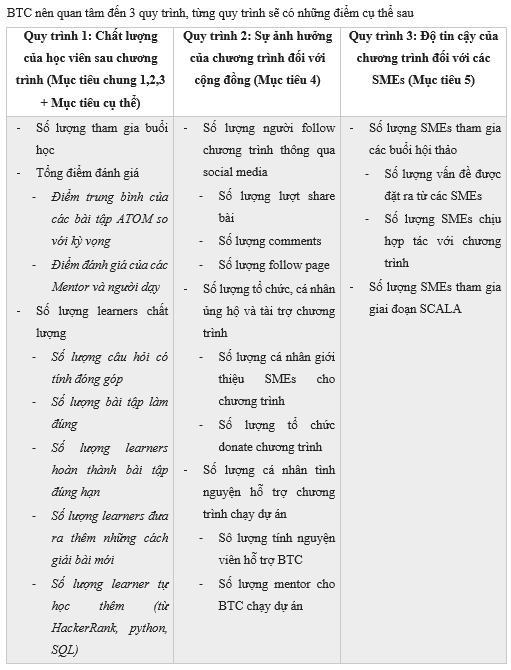

In [39]:
#2.	BTC sẽ quan tâm đến những chủ đề/quy trình gì để đạt được Mục Đích trong (1)?
from IPython.display import Image
Image(filename='atom-2.png')

**3. Làm sao để đo lường các điểm trong (2)? => Metrics?**

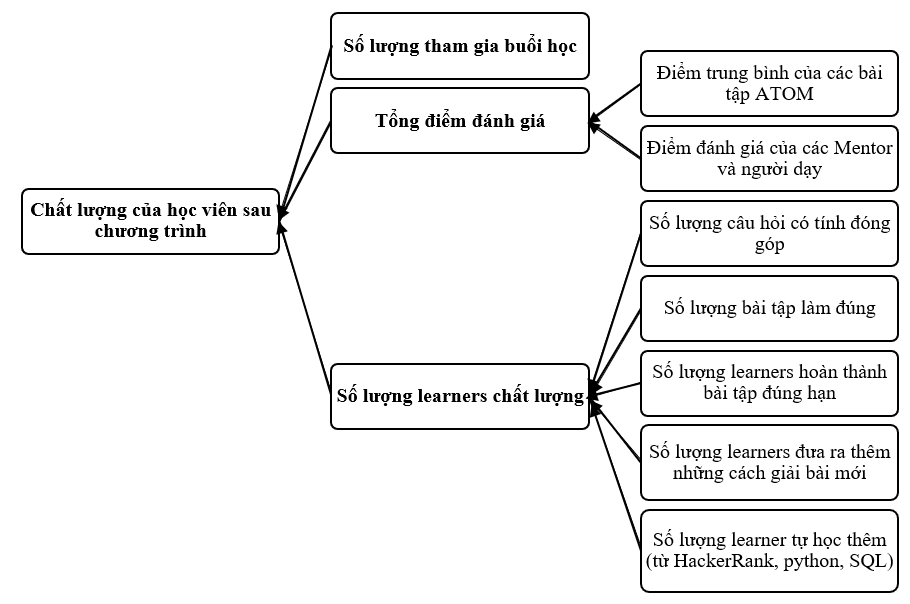

In [40]:
from IPython.display import Image
Image(filename='atom-3.1.png')

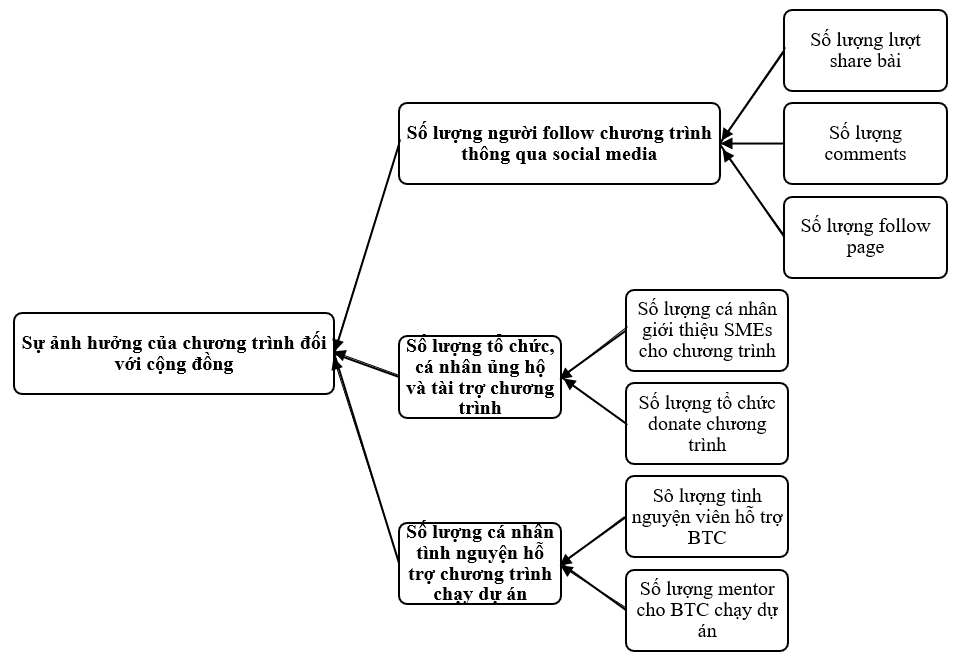

In [42]:
from IPython.display import Image
Image(filename='atom-3.2.png')

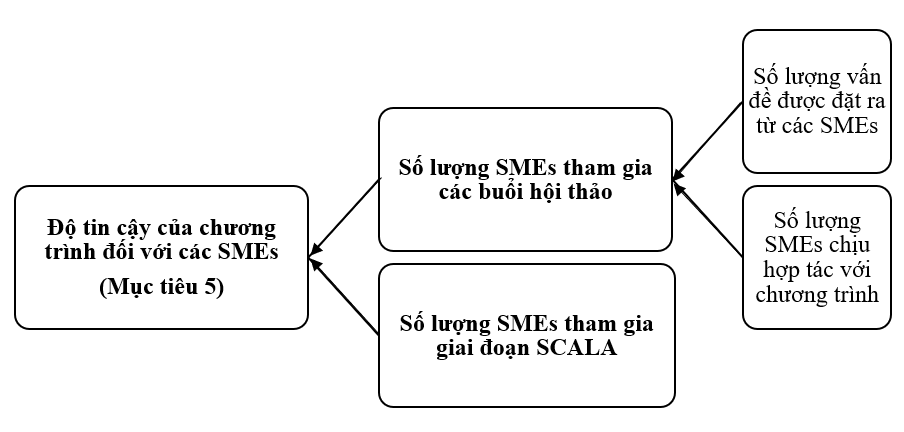

In [43]:
from IPython.display import Image
Image(filename='atom-3.3.png')

**4. Dựa vào các data đã có như liệt kê trong STEP 0:**

Chỉ dùng những data sẵn có, ta có thể đo lường và thiết kế những metrics nào bạn đã liệt kê trong (3)?



*   Nếu dùng những data sẵn có và nhanh chóng nhất, chúng ta có thể sử dụng metric 1 đầu tiên, theo quá trình lâu dài của chương trình có thể sử dụng metric 2 và sau khi kết thúc chương trình nên sử dụng thêm metric 3 để dánh giá hiệu quả toàn bộ dự án và chương trình



**4. Dựa vào các data đã có như liệt kê trong STEP 0:**

Tham khảo Slack API và hình dung về các thông tin DataCracy có khả năng thu thập, bạn sẽ đề xuất DataCracy thu thập thêm những thông tin gì?
-	Số lượng learners tương tác trên Slack (đặt câu hỏi, trả lời câu hỏi của các bạn học viên khác, trao đổi, thảo luận với group với learners và mentors)
-	Số lượng bài nộp đúng hạn
-	Số lượng learners đặt câu hỏi trên Slack hay, có tính đóng góp
-	Số lượng review bài của các bài tập và trao đổi về bài tập thông qua số lượng messages


# STEP 2: TỔ CHỨC THÔNG TIN


> Thu thập và hệ thống lại các thông tin



In [44]:
## Hints: info() để check các thông tin (Column), số dòng (Count), và Data Type của mỗi cột
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       75 non-null     object
 1   name          75 non-null     object
 2   display_name  50 non-null     object
 3   real_name     75 non-null     object
 4   title         6 non-null      object
 5   is_bot        75 non-null     bool  
dtypes: bool(1), object(5)
memory usage: 3.1+ KB


# TODO#2: List Down
Trả lời các câu hỏi sau:


1.   Có những thông tin gì trong các bảng data ở STEP 0? Ý nghĩa của mỗi trường (Column). Hints: Đọc thêm Slack API để hiểu ý nghĩa data trả về
2.   Data Type của mỗi trường
3.   Có NULL không? (Non-Null Count <> entries)


*   Ta sẽ dùng công cụ: QuickDBD cho Assignment này => Tham khảo Sample lúc mở tool
*   Copy điền đoạn text vào tools






In [ ]:
# Dtype obj: object -> string, bool, int, float
# NULL - Nếu có null count < số entries

'''
# Ví dụ  bảng user_df 
user_df
-
user_id string 
name string
display_name NULL string
real_name string
title NULL string
is_bot bool

# Điền tiếp các bản còn lại
channel_df
-
channel_id string 
channel_name string
is_channel bool
creator string 
create_at datetime
topics NULL string
purpose NULL string
num_members int

msg_df
-
channel_id string 
msg_id string 
msg_ts string
user_id string 
latest_reply datetime
reply_user_count int
reply_users string
github_link NULL string

'''

# STEP 3: NGUYÊN TẮC CẦN ÁP DỤNG


# TODO#3: Rules & Logics
Dựa vào các kiến nghị TODO#1 và Quan sát ở TODO#2, bạn có những đề xuất gì về rules trong vận hành để cải thiện thông tin và quan sát?
**Về mặt vận hành**
> Rules gì cần áp dụng cho cách thức nhập data?
**Một số gợi ý**
1.   Rules để cải thiện tỷ lệ NULL trong các bạn? (Ví dụ: Bắt buộc nhập các thông tin trên Slack? Có cần thiết không?)
2.   Làm sao để xác định message nào là bài submit assigment? Message nào là review? Message vào là các nội dung không liên quan? (Ví dụ: Users để tag #submit, #review?)
3.   ...
**Về mặt data**
> Logics gì cần áp dụng để kiểm tra sự hợp lý của Data?
**Một số gợi ý**
1.   Hai users trùng tên?
2.   Ngày latest reply > ngày post?
3.   Ngày post trong năm 2021 (sau khi dự án DataCracy thành lập)
4.   Mentor Group nào sẽ chỉ post trong channel discussion của group đó?
5.   ...
Bạn có thể đưa các đề xuất để đưa vào vận hành nhằm cải thiện data và giúp bạn đo lường theo dõi các metrics đã được liệt kể trong TODO#1









**RULES khi giao tiếp trên Slack**

1. Cách thức tạo User mới:
- User nên ghi rõ thông tin như Họ tên đầy đủ và nghề nghiệp hiện tại

2. Cách thức tạo messages:

- Nếu messages là đóng góp, xây dựng bài cần thêm hashtag #raisehand 
- Nếu messages là câu hỏi thì cần thêm hashtag #question
- Nếu messages là nộp bài tập thì cần thêm hashtag #submit #assignmentX
- Nếu messages là review bài tập thì cần thêm hashtag #review
    
3. Cách thức nộp bài
- Nộp đúng bài tập cần nộp vào channel đã đăng bài tập 
- Thêm hashtag vào mỗi messages tương ứng

**Về mặt data Logics gì cần áp dụng để kiểm tra sự hợp lý của Data? Một số gợi ý**

1. Nếu có hai user trùng tên -> hệ thống check trùng -> tiếp tục check đến nghề nghiệp 

=> Nếu trùng họ tên và nghề nghiệp, auto 2 người này là 1

=> Nếu trùng họ tên và khác nghề nghiệp, có thể 2 người này khác nhau

2. Validate ngày tháng
* Ngày submit bài tập phải lớn hơn ngày tạo channel tương ứng với bài tập đó
* Ngày submit bài tập phải nhỏ hơn ngày tạo channel cho bài tập kế tiếp 

Ví dụ 

    - Ngày submit bài assignment 3 > ngày tạo channel #atom-assignment 3 không lớn hơn 5 ngày
    (Giả thiết channel được tạo vào ngày chủ nhật => Tránh assignment 3 nộp vào #atom-assignment 2)
    - Ngày submit bài assignment 3 < ngày tạo channel #atom-assignment 4
* Ngày review bài tập phải lớn hơn ngày submit bài tập 
* Các mốc thời gian trong Slack đều phải nhỏ hơn ngày DataCracy được tạo

# STEP 4: TỔ CHỨC BẢNG - PRIMARY KEYS

In [46]:
## Hints: nunique() để check số giá trị unique của từng trường
user_df.nunique()

user_id         75
name            75
display_name    49
real_name       73
title            5
is_bot           2
dtype: int64

# TODO#4: Tables & PK


1.   Nhìn lại diagram của TODO#2 trong Quick DBD Diagram: Có bảng nào bạn nghĩ nên gộp lại, hay tách ra không? Vì sao?
2.   Tìm Primary Key (PK): Unique cho từng dòng và Không NULL

> Primary Key (PK) là trường giá trị/ID unique cho mỗi dòng của bảng. Hay nói cách khác, không có hai dòng trùng lặp (duplicate ID).

*   Fun fact để nhớ: Thử tưởng tượng nếu 2 người không quen biết, có cùng Số TK Ngân hàng :(((




In [ ]:
## Copy lại phần text của TODO#2
## Đặt PK bên cạnh col bạn chọn làm PK
# Dtype obj: object -> string, bool, int, float
# NULL - Nếu có null count < số entries

'''
# Ví dụ  bảng user_df 
user_df
-
user_id string PK
name string
display_name NULL string
real_name string
title NULL string
is_bot bool

# Điền tiếp các bản còn lại
channel_df
-
channel_id string PK
channel_name string
is_channel bool
creator string FK >- user_df.user_id
create_at datetime
topics NULL string
purpose NULL string
num_members int

msg_df
-
channel_id string FK >- channel_df.channel_id
msg_id string PK
msg_ts string
user_id string FK >- user_df.user_id
latest_reply datetime
reply_user_count int
reply_users string
github_link NULL string
'''

# STEP 5: MỐI QUAN HỆ GIỮA CÁC BẢNG

# TODO#5: FK & Mapping¶
Như đã giới thiệu ở phần Concept, keys quan trọng trong Relational DB vì nó thể hiện mối quan hệ giữa các bạn, thông qua key, cho phép ta nối các bảng với nhau. Bây giờ ta sẽ đi tìm FK (Foreign Key):


> Foreign Key: Là các keys nằm trong một bảng để liên kết với PK trong bảng khác


1.   Đâu là các ID trong bảng, nhưng không phải là PK (do thoả điều kiện unique)?
2.   Các ID này dẫn đến PK nào trong các bảng còn lại?
3.   Trong các key được nối với nhau, xác định kiểu quan hệ:


*   n:1 - PK ở bảng gốc lặp lại nhiều lần (nhiều dòng) ở bản chứa FK
*   1:1 - PK ở bảng gốc chỉ nối với 1 dòng

**Ví dụ**: channel_id string FK >- channel_df.channel_id






In [ ]:
## Copy lại phần text của TODO#2
## Đặt FK bên cạnh col bạn chọn làm FK
## Và thể hiện mối quan hệ bằng: id >- bảng_gốc.id (FK là PK trong bảng gốc)
'''
# Ví dụ  bảng user_df 
user_df
-
user_id string
name string
display_name NULL string
real_name string
title NULL string
is_bot bool

# Điền tiếp các bản còn lại
channel_df
-
channel_id string
channel_name string
is_channel bool
creator string FK >- user_df.user_id
create_at 
topics NULL string
purpose NULL string
num_members number

msg_df
-
channel_id string FK >- channel_df.channel_id
msg_id string
msg_ts string
user_id string
latest_reply 
reply_user_count number
reply_users string
github_link NULL string

'''

# STEP 6: DIAGRAM & TEST
Sau khi làm hết TODO#5 bạn sẽ được 1 DB Diagram như trong sample mẫu bên dưới (Sample này không phải của DataCracy)

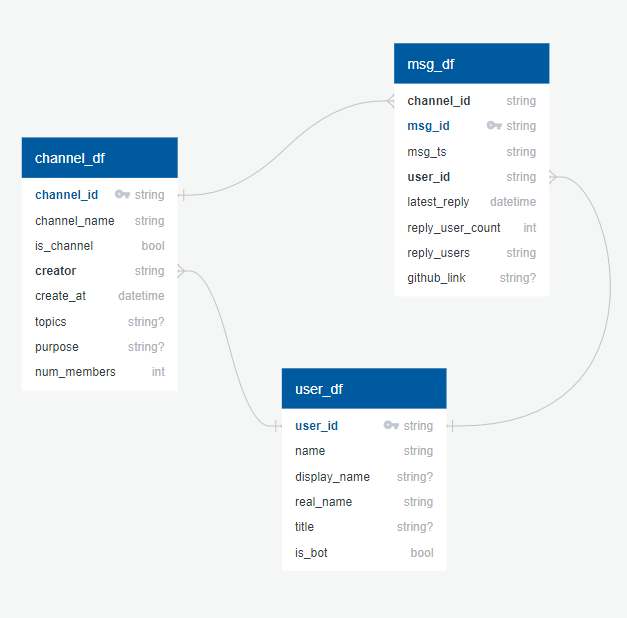

In [47]:
from IPython.display import Image
Image(filename='dbdiagram.png')

In [48]:
## Đoạn code dưới join 2 bảng user_df vằ dtc_groups bằng key name => Tạo thành bảng members_df
#Để comment trong SQL dùng -- tương đường với ## trong Python
SQL_dim_members = '''
-- Để comment trong SQL dùng -- tương đường với ## trong Python
CREATE TABLE members_df AS
SELECT 
  t1.*,
  t2.DataCracy_role
FROM user_df AS t1
JOIN dtc_groups AS t2
ON t1.name = t2.name
'''

In [49]:
con = duckdb.connect(database=':memory:', read_only=False) # -> Tạo DB connection
# create a table
con.execute(SQL_dim_members) # -> Chạy đoạn lệch SQL
con.execute("SELECT * FROM members_df LIMIT 10").fetch_df() # -> In 10 dòng đầu tiên của bảng members_df ra Dataframe

,user_id,name,display_name,real_name,title,is_bot,DataCracy_role
0,USLACKBOT,slackbot,Slackbot,Slackbot,NaN,False,BTC
1,U01AT4T75JB,loclexuan26392,Loc Le Xuan,Loc Le Xuan,NaN,False,BTC
2,U01AVDY7JET,locle.ds,Loc Le Xuan,Loc Le Xuan,NaN,False,BTC
3,U01BE2PR6LU,maianhdang.ftu,MAD,Dặng Huỳnh Mai Anh,Technical Contents,False,BTC
4,U01C48T7S1J,huyenhoang.design,Thanh Huyen Hoang,Thanh Huyen Hoang,NaN,False,BTC
5,U01CMTYB7EU,dr.tringuyenzmc,NaN,Dr Tringuyenzmc,NaN,False,BTC
6,U01GQR2FE93,khanguyenwk,NaN,Kha Nguyen,NaN,False,Volunteer
7,U01HARCHNKU,linhphan,NaN,Phan Linh,NaN,False,BTC
8,U01JQ5TUP0B,tt.thuchuyen,NaN,Tt Thuchuyen,NaN,False,BTC
9,U01JQ5U1RPV,thuongthuong.dv,NaN,Thuong Do,NaN,False,BTC


In [50]:
con.execute("SELECT * FROM channel_df LIMIT 5").fetch_df() # -> In 5 dòng đầu tiên của bảng channel_df ra Dataframe

,channel_id,channel_name,is_channel,creator,created_at,topics,purpose,num_members
0,C01B4PVGLVB,general,True,U01BE2PR6LU,2020-09-23 10:25:03,NaN,This is the one channel that will always inclu...,65
1,C01BYH7JHB5,contents,True,U01BE2PR6LU,2020-10-05 07:28:09,NaN,NaN,12
2,C01CAMNCJJV,branding-design,True,U01AVDY7JET,2020-10-05 03:16:30,NaN,NaN,9
3,C01U6P7LZ8F,atom-assignment1,True,U01BE2PR6LU,2021-04-17 07:00:04,Assigment#1 - Python Basics &amp; Spreadsheet ...,Where learners submit assignments and give rev...,44
4,C01UL6K1C7L,atom-week1,True,U01BE2PR6LU,2021-04-16 17:44:32,TOPIC: Data Strategy. Metrics Design. Spreadsh...,TOPIC: Data Strategy. Metrics Design. Spreadsh...,43


In [51]:
con.execute("SELECT * FROM msg_df LIMIT 5").fetch_df() # -> In 5 dòng đầu tiên của bảng msg_df ra Dataframe

,channel_id,msg_id,msg_ts,user_id,latest_reply,reply_user_count,reply_users,github_link
0,C01B4PVGLVB,48ba219d-fda8-40f2-be65-00735c058071,2021-05-25 04:59:27.000600,U01BE2PR6LU,2021-05-25 06:04:44.006500,4,NaN,NaN
1,C01B4PVGLVB,89919b55-bfe9-4c15-bf45-3021048c7c28,2021-05-24 11:49:08.061100,U01BE2PR6LU,1970-01-01 00:00:00.000000,0,NaN,NaN
2,C01B4PVGLVB,18467584-5810-4bb9-80fe-4b92af9b28d0,2021-05-23 16:26:04.057000,U01UTGT8CVA,2021-05-24 08:36:52.058100,2,NaN,NaN
3,C01B4PVGLVB,dfd2bf1a-69a1-4ac3-aacb-e2daaae8cc04,2021-05-23 07:57:36.055300,U01BE2PR6LU,1970-01-01 00:00:00.000000,0,NaN,NaN
4,C01B4PVGLVB,fd5d6cf7-415c-459a-818c-72835fd2479a,2021-05-22 23:28:27.053900,U01BE2PR6LU,1970-01-01 00:00:00.000000,0,NaN,NaN


In [55]:
## Đoạn code dưới: Theo từng channel, count số message (phải join với bảng channel_df để lấy tên channel)
SQL = '''
SELECT 
  ch.channel_name,
  COUNT(DISTINCT ms.msg_id) AS msg_cnt
FROM msg_df AS ms
JOIN channel_df AS ch
ON ms.channel_id = ch.channel_id
GROUP BY ch.channel_name 
ORDER BY COUNT(DISTINCT ms.msg_id) DESC
'''
con.execute(SQL).fetch_df()

,channel_name,msg_cnt
0,general,42
1,atom-assignment1,42
2,atom-assignment2,42
3,atom-assignment3,38
4,discuss-group1,32
5,discuss-group3,16
6,topics-python,13
7,discuss-group4,11
8,atom-assignment4,9
9,atom-week1,6


In [57]:
## Đoạn code dưới: Lấy top 3 mentors post nhiều message nhất trong discuss-group của các nhóm
SQL = '''
WITH msg_cnt AS (
  SELECT 
    user_id,
    channel_id,
    COUNT(msg_id) AS msg_cnt
  FROM msg_df 
  GROUP BY 1, 2
)
SELECT
  mb.real_name,
  ch.channel_name,
  ms.msg_cnt,
  mb.DataCracy_role
FROM msg_cnt AS ms
JOIN members_df AS mb 
ON ms.user_id = mb.user_id
JOIN channel_df AS ch 
ON ms.channel_id = ch.channel_id
WHERE mb.DataCracy_role LIKE 'Mentor%'
AND ch.channel_name LIKE 'discuss-group%' 
ORDER BY ms.msg_cnt DESC 
LIMIT 3 
'''
con.execute(SQL).fetch_df()

,real_name,channel_name,msg_cnt,DataCracy_role
0,Phu NDT,discuss-group1,11,Mentor_Gr1
1,Nguyễn Quang Long,discuss-group3,9,Mentor_Gr3
2,Thuy Nguyen,discuss-group4,4,Mentor_Gr4


# TODO#6: SQL

In [63]:
assignment = '''
SELECT * 
  FROM msg_df 
  WHERE channel_id IN (
    SELECT channel_id
    FROM channel_df
    WHERE channel_name like 'atom_assignment%'
    GROUP BY channel_id
  )
  AND user_id IN (
    SELECT user_id 
    FROM members_df 
    WHERE DataCracy_role like 'Learner%'
    GROUP BY user_id
  )
'''
con.register('assignment', con.execute(assignment).fetch_df())

SQL_1 = '''
WITH best_msg AS (
  SELECT
    channel_id,
    user_id,
    COUNT(msg_id) AS msg_cnt
  FROM msg_df
  GROUP BY 1, 2
)
SELECT 
  ch.channel_name, 
  mb.name,
  bs.msg_cnt,
  mb.DataCracy_role
FROM best_msg AS bs
JOIN channel_df AS ch
ON ch.channel_id = bs.channel_id
JOIN members_df AS mb
ON bs.user_id = mb.user_id
WHERE mb.DataCracy_role LIKE 'Learner%'
ORDER BY bs.msg_cnt DESC
LIMIT 10
'''

con.execute(SQL_1).fetch_df()

,channel_name,name,msg_cnt,DataCracy_role
0,discuss-group1,chuviethong.vn,11,Learner_Gr1
1,atom-assignment3,hanh.nguyenhong2511,4,Learner_Gr4
2,topics-python,levy6543,3,Learner_Gr4
3,atom-assignment1,hanh.nguyenhong2511,2,Learner_Gr4
4,atom-assignment1,danhpcv,2,Learner_Gr3
5,discuss-group2,ngocha.nt1476,2,Learner_Gr2
6,atom-assignment2,hanh.nguyenhong2511,2,Learner_Gr4
7,atom-assignment1,chuviethong.vn,2,Learner_Gr1
8,atom-assignment1,tranquan030894,2,Learner_Gr4
9,atom-week1,nvlinh.dth,2,Learner_Gr1


In [64]:
#Learners groups nào hoạt động tích cực trên Slack nhất? (tính theo message count)?
SQL_1 = '''
SELECT DataCracy_role, COUNT(msg_id) AS 'msg_cnt'
FROM members_df mb JOIN msg_df ms ON mb.user_id = ms.user_id

WHERE DataCracy_role like 'Learner%' AND 'msg_cnt'= (SELECT MAX('msg_cnt')
                                                        FROM members_df mb JOIN msg_df ms ON mb.user_id = ms.user_id
                                                        WHERE DataCracy_role LIKE 'Learner%'
                                                        GROUP BY DataCracy_role)
GROUP BY DataCracy_role        
ORDER BY msg_cnt DESC LIMIT 1        
'''
con.execute(SQL_1).fetch_df()

,DataCracy_role,msg_cnt
0,Learner_Gr4,45


In [67]:
SQL_2_1 = '''
SELECT ms.user_id, mb.real_name, DataCracy_role, channel_name

FROM members_df mb JOIN msg_df ms on mb.user_id = ms.user_id
JOIN channel_df ch ON ch.channel_id=ms.channel_id

WHERE ms.msg_ts = (SELECT Min(ms.msg_ts) 
                    FROM msg_df ms join channel_df ch ON ms.channel_id = ch.channel_id 
                        JOIN members_df mb ON mb.user_id = ms.user_id
                    WHERE ch.channel_name = 'atom-assignment1' AND ms.github_link != 'NaN' 
                        AND mb.DataCracy_role like 'Learner%' )
'''
con.execute(SQL_2_1).fetch_df()

,user_id,real_name,DataCracy_role,channel_name
0,U01UMJ5AQ0K,Hưng Dương Phan Nam,Learner_Gr1,atom-assignment1


In [69]:
SQL_2_2 = '''
SELECT ms.user_id, mb.real_name, DataCracy_role, channel_name

FROM members_df mb join msg_df ms ON mb.user_id = ms.user_id
JOIN channel_df ch ON ch.channel_id=ms.channel_id

WHERE ms.msg_ts = (SELECT Min(ms.msg_ts) 
                    FROM msg_df ms join channel_df ch ON ms.channel_id = ch.channel_id 
                        join members_df mb ON mb.user_id = ms.user_id
                    WHERE ch.channel_name = 'atom-assignment2' AND ms.github_link != 'NaN' 
                        AND mb.DataCracy_role like 'Learner%' )
'''
con.execute(SQL_2_2).fetch_df()

,user_id,real_name,DataCracy_role,channel_name
0,U01UQGZHSTZ,Toan Tran,Learner_Gr2,atom-assignment2


In [70]:
SQL_2_3 = '''
SELECT ms.user_id, mb.real_name, DataCracy_role, channel_name

FROM members_df mb JOIN msg_df ms ON mb.user_id = ms.user_id
JOIN channel_df ch ON ch.channel_id=ms.channel_id

WHERE ms.msg_ts = (SELECT MIN(ms.msg_ts) 
                    FROM msg_df ms join channel_df ch ON ms.channel_id = ch.channel_id 
                        join members_df mb ON mb.user_id = ms.user_id
                    WHERE ch.channel_name = 'atom-assignment3' AND ms.github_link != 'NaN' 
                        AND mb.DataCracy_role like 'Learner%' )
'''
con.execute(SQL_2_3).fetch_df()

,user_id,real_name,DataCracy_role,channel_name
0,U01UTGRMGEQ,Hanh Nguyen,Learner_Gr4,atom-assignment3


In [71]:
SQL_2_4 = '''
SELECT ms.user_id, mb.real_name, DataCracy_role, channel_name

FROM members_df mb join msg_df ms ON mb.user_id = ms.user_id
JOIN channel_df ch ON ch.channel_id=ms.channel_id

WHERE ms.msg_ts = (SELECT MIN(ms.msg_ts) 
                    FROM msg_df ms join channel_df ch ON ms.channel_id = ch.channel_id 
                        JOIN members_df mb ON mb.user_id = ms.user_id
                    WHERE ch.channel_name = 'atom-assignment4' AND ms.github_link != 'NaN' 
                        AND mb.DataCracy_role like 'Learner%' )
'''
con.execute(SQL_2_4).fetch_df()

,user_id,real_name,DataCracy_role,channel_name
0,U01UJ9M3P1T,Cao Nguyen Huy Hoang,Learner_Gr2,atom-assignment4


In [72]:
#learner nộp bài atom-assignment1 trễ nhất
SQL_3_1 = '''
SELECT ms.user_id, mb.real_name, DataCracy_role, ms.msg_ts

FROM members_df mb JOIN msg_df ms ON mb.user_id = ms.user_id

WHERE ms.msg_ts = (SELECT MAX(ms.msg_ts) 
                    FROM msg_df ms JOIN channel_df ch ON ms.channel_id = ch.channel_id 
                        JOIN members_df mb ON mb.user_id = ms.user_id
                    WHERE ch.channel_name = 'atom-assignment1' AND ms.github_link != 'NaN' 
                        AND mb.DataCracy_role like 'Learner%' )
'''
con.execute(SQL_3_1).fetch_df()

,user_id,real_name,DataCracy_role,msg_ts
0,U01UJ9LG5U5,Danh Phan,Learner_Gr3,2021-05-10 04:51:46.004700


In [73]:
#learner nộp bài atom-assignment2 trễ nhất
SQL_3_2 = '''
SELECT ms.user_id, mb.real_name, DataCracy_role, ms.msg_ts

FROM members_df mb JOIN msg_df ms ON mb.user_id = ms.user_id

WHERE ms.msg_ts = (SELECT MAX(ms.msg_ts) 
                    FROM msg_df ms JOIN channel_df ch ON ms.channel_id = ch.channel_id 
                        JOIN members_df mb ON mb.user_id = ms.user_id
                    WHERE ch.channel_name = 'atom-assignment2' AND ms.github_link != 'NaN' 
                        AND mb.DataCracy_role like 'Learner%' )
'''
con.execute(SQL_3_2).fetch_df()

,user_id,real_name,DataCracy_role,msg_ts
0,U01UTGRMGEQ,Hanh Nguyen,Learner_Gr4,2021-05-22 05:39:34.015500


In [76]:
#learner nộp bài atom-assignment3 trễ nhất
SQL_3_3 = '''
SELECT ms.user_id, mb.real_name, DataCracy_role, ms.msg_ts

FROM members_df mb JOIN msg_df ms ON mb.user_id = ms.user_id

WHERE ms.msg_ts = (SELECT MAX(ms.msg_ts) 
                    FROM msg_df ms JOIN channel_df ch ON ms.channel_id = ch.channel_id 
                        JOIN members_df mb ON mb.user_id = ms.user_id
                    WHERE ch.channel_name = 'atom-assignment3' AND ms.github_link != 'NaN' 
                        AND mb.DataCracy_role LIKE 'Learner%' )
'''
con.execute(SQL_3_3).fetch_df()

,user_id,real_name,DataCracy_role,msg_ts
0,U01USGKQ771,Ngo Thi Minh Trang,Learner_Gr1,2021-05-27 15:30:16.003200


In [77]:
#Learner nào chưa nộp bài Assignment 3?
SQL_4 = '''
SELECT mb.user_id, mb.real_name, DataCracy_role
FROM members_df mb
WHERE mb.DataCracy_role like'Learner%' and 
mb.user_id not in (SELECT ms.user_id FROM msg_df ms JOIN channel_df ch ON ms.channel_id = ch.channel_id 
                        JOIN members_df mb ON mb.user_id = ms.user_id
                        WHERE ch.channel_name = 'atom-assignment3' AND ms.github_link != 'NaN'
                                            AND mb.DataCracy_role LIKE'Learner%'

)

'''
con.execute(SQL_4).fetch_df()
#Tại sao em đã nộp bài trước deadline lại có tên trong danh sách này???

,user_id,real_name,DataCracy_role
0,U01U6JM6LEB,Viet Hoang,Learner_Gr4
1,U01U8CAMGB1,Ngoc Huyen,Learner_Gr1
2,U01UEJG8KHU,Trang Nguyễn,Learner_Gr3
3,U01UJ9M5TU5,Nguyen Thi Kim Minh,Learner_Gr2
4,U01UMBXJLHG,Nguyen Linh,Learner_Gr1
5,U01UMC08KL2,Minh-Thu Nguyen Hoang,Learner_Gr4
6,U01UMC0N5U2,Việt Hồng Chu,Learner_Gr1
7,U01UTGRP0HJ,Tran Pham,Learner_Gr3
8,U01UTGRQS9J,Linh Vu,Learner_Gr4
9,U01VB63LRNC,anh thu nguyen huynh,Learner_Gr4


In [78]:
#Learner nào chưa nộp bất kỳ 1 assignment nào?
SQL_5 = '''
SELECT mb.user_id, mb.real_name, DataCracy_role
FROM members_df mb
WHERE mb.DataCracy_role LIKE'Learner%' AND
mb.user_id not in (SELECT ms.user_id FROM msg_df ms JOIN channel_df ch ON ms.channel_id = ch.channel_id 
                        JOIN members_df mb ON mb.user_id = ms.user_id
                    WHERE ch.channel_name LIKE 'atom-assignment_' AND ms.github_link != 'NaN'
                                            AND mb.DataCracy_role like'Learner%'
)

'''
con.execute(SQL_5).fetch_df()

,user_id,real_name,DataCracy_role
0,U01U8CAMGB1,Ngoc Huyen,Learner_Gr1
1,U01UMBXJLHG,Nguyen Linh,Learner_Gr1
2,U01VBFY2E59,Gia Hoang Tran,Learner_Gr1
3,U0233KHLM2M,Vuthanhdat Contact,Learner_Gr4


In [79]:
#Tỷ lệ % Learner đã nộp assignment 1, 2, 3? (*giả sử có message trong channel atom-assignment, được tính là đã submit*)
SQL_6 = '''
SELECT t1.channel_name, FORMAT(t1.submited_cnt * 100/ t.learner_cnt,'P') AS 'Tỉ lệ nộp bài (%)'
FROM (SELECT COUNT(user_id) AS 'learner_cnt'
        FROM members_df
        WHERE DataCracy_role LIKE 'Learner%' ) t, 
    (SELECT COUNT(DISTINCT ms.user_id) AS 'submited_cnt', ch.channel_name
        FROM msg_df ms JOIN channel_df ch ON ms.channel_id = ch.channel_id
            JOIN members_df mb ON mb.user_id = ms.user_id
        WHERE channel_name LIKE'atom-assignment_' AND mb.DataCracy_role LIKE 'Learner%' and ms.github_link != 'NaN'
        GROUP BY ch.channel_name) t1
'''
con.execute(SQL_6).fetch_df()

,channel_name,Tỉ lệ nộp bài (%)
0,atom-assignment1,71
1,atom-assignment2,79
2,atom-assignment3,66
3,atom-assignment4,10


In [80]:
#Tỷ lệ % Learner đã submit bài và dc review trong assignment 1, 2, 3?
SQL_7 = '''
SELECT t1.channel_name, FORMAT(t1.submited_cnt * 100/ t.learner_cnt, 'P') AS 'Phần trăm bài được review (%)'
FROM (SELECT COUNT(user_id) AS 'learner_cnt'
        FROM members_df
        WHERE DataCracy_role like 'Learner%' ) t, 
    (SELECT COUNT(DISTINCT ms.user_id) AS 'submited_cnt', ch.channel_name
        FROM msg_df ms JOIN channel_df ch ON ms.channel_id = ch.channel_id
            JOIN members_df mb ON mb.user_id = ms.user_id
        WHERE channel_name LIKE'atom-assignment_' AND mb.DataCracy_role LIKE 'Learner%' AND ms.github_link != 'NaN'
        AND ms.reply_user_count > 0
        GROUP BY ch.channel_name) t1
'''
con.execute(SQL_7).fetch_df()

,channel_name,Phần trăm bài được review (%)
0,atom-assignment1,61
1,atom-assignment2,74
2,atom-assignment3,33
3,atom-assignment4,2


In [81]:
#Learners theo Group nào có tỷ lệ % hoàn thành bài tập cao nhất?
SQL_8 = '''
WITH report_byGroup AS(
SELECT t1.channel_name,t1.DataCracy_role, (t1.submited_cnt * 100/ t.learner_cnt) AS 'Ti_le_nop'
FROM (SELECT COUNT(user_id) AS 'learner_cnt', DataCracy_role
        FROM members_df
        WHERE DataCracy_role LIKE 'Learner%'
        GROUP BY DataCracy_role ) t JOIN
    (SELECT COUNT(DISTINCT ms.user_id) AS 'submited_cnt', ch.channel_name,mb.DataCracy_role 
        FROM msg_df ms JOIN channel_df ch ON ms.channel_id = ch.channel_id
            JOIN members_df mb ON mb.user_id = ms.user_id
        WHERE channel_name like'atom-assignment_' AND mb.DataCracy_role LIKE 'Learner%' AND ms.github_link != 'NaN'
        GROUP BY ch.channel_name,mb.DataCracy_role  ) t1 
    ON t.DataCracy_role = t1.DataCracy_role
)
SELECT re.DataCracy_role, ROUND(AVG(re.Ti_le_nop),2) AS 'Phần trăm hoàn thành cao nhất (%)'
FROM report_byGroup re
GROUP BY re.DataCracy_role
HAVING  AVG(re.Ti_le_nop) >= all(select avg(Ti_le_nop)
FROM report_byGroup
GROUP BY DataCracy_role)

'''
con.execute(SQL_8).fetch_df()

,DataCracy_role,Phần trăm hoàn thành cao nhất (%)
0,Learner_Gr2,66.25


In [ ]:
## Ví dụ: Đoạn code (Pandas) sau làm
## 1. Group by channel_id
## 2. Count các message
## 3. Sắp xếp theo thứ tự số message từ cao xuống thấp (ascending=False)
## 4. Filter lấy Top 5
msg_df.groupby('channel_id')['msg_id'].count().sort_values(ascending=False).head(5)

channel_id
C021FSDN7LJ    42
C01U6P7LZ8F    42
C01B4PVGLVB    42
C0227A51SAY    37
C0220KU9399    32
Name: msg_id, dtype: int64

In [ ]:
## Kết quả tương ứng bằng SQL
SQL = '''
  SELECT 
    channel_id,
    COUNT(msg_id) AS msg_cnt
  FROM msg_df 
  GROUP BY 1
  ORDER BY COUNT(msg_id) DESC
  LIMIT 5
'''
con.execute(SQL).fetch_df()

,channel_id,msg_cnt
0,C01U6P7LZ8F,42
1,C01B4PVGLVB,42
2,C021FSDN7LJ,42
3,C0227A51SAY,37
4,C0220KU9399,32
